In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('finished_processed.csv')
print(dataset.keys())
print(dataset.shape)
dataset.drop(['backers_count', 'usd_pledged'], axis=1, inplace=True)
target = dataset['state']
features = dataset.drop(['state'], axis=1)
features.shape
#from sklearn.preprocessing import LabelEncoder
#lb = LabelEncoder()
#features = features.apply(lb.fit_transform)

Index(['backers_count', 'category', 'country', 'creator', 'currency', 'goal',
       'staff_pick', 'state', 'usd_pledged', 'location', 'blurb_length',
       'duration'],
      dtype='object')
(173823, 12)


(173823, 9)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
print(X_train.shape)

(130367, 9)


In [4]:
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [5]:
predicted = rf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - rf.oob_score_)
importances = [(features.keys()[i], rf.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.771078792342
0.237590801353
[('category', 0.24829047323000908), ('country', 0.014141371887226655), ('creator', 0.15671834565293541), ('currency', 0.012779945388289032), ('goal', 0.17979579977436405), ('staff_pick', 0.074970443950096902), ('location', 0.13955950262498942), ('blurb_length', 0.094272346447065003), ('duration', 0.079471771045024536)]


In [ ]:
%%capture --no-stdout
from collections import OrderedDict

min_est = 10
max_est = 100

max_features = [0.2, 0.33, 0.5, 0.8, "sqrt", "log2", None]

error_scores = OrderedDict((l, []) for l in max_features)

for mf in max_features:
    
    rf_test = RandomForestClassifier(n_estimators = min_est, max_features = mf, oob_score = True, random_state = 1,
                                     warm_start = True, n_jobs = -1)
    for i in range(min_est, max_est + 1, 5):
        rf_test.set_params(n_estimators = i)
        rf_test.fit(X_train, y_train)
        oob_error = 1 - rf_test.oob_score_
        error_scores[mf].append((i, oob_error))
        print(str(mf) + ": " + str(i) + ", " + str(oob_error))

In [ ]:
plt.figure(figsize=(16,12))
for mf, rf_err in error_scores.items():
    xs, ys = zip(*rf_err)
    plt.plot(xs, ys, label=str(mf))
plt.xlim(min_est, max_est)
plt.xlabel("n_estimators")
plt.ylabel("OOB Error Score")
plt.legend(title="max_features", loc="upper right")
plt.show();

In [ ]:
rf_optimized = RandomForestClassifier(n_estimators = 100, max_features = None, oob_score = True, random_state = 1,
                                      min_samples_leaf=20, n_jobs = -1)
rf_optimized.fit(X_train, y_train)
predicted = rf_optimized.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - rf_optimized.oob_score_)
importances = [(features.keys()[i], rf_optimized.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

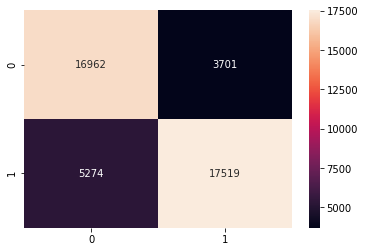

In [17]:
from sklearn.metrics import confusion_matrix

cfmtx = confusion_matrix(y_test, predicted)
sns.heatmap(cfmtx, annot=True, fmt='g')

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

rf = RandomForestClassifier(n_estimators=100)
# We want to have bootstrap=True for oob_error
param_dist = {"max_depth": [3, None],
              "max_features": [0.8, "sqrt", None],
              "min_samples_split": sp_randint(2, 15),
              "min_samples_leaf": sp_randint(1, 15),
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": True,
              "n_jobs": -1}
rsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, n_jobs=-1)
rsearch.fit(X_train, y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [3, None], 'max_features': [0.8, 'sqrt', None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025AD4A0E4A8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025AD4A0E5F8>, 'bootstrap': [True], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scori

In [10]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(rsearch.cv_results_)
print(rsearch.best_score_)
print(rsearch.best_estimator_)

Model with rank: 1
Mean validation score: 0.7906 (std: 0.0009)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.7902 (std: 0.0007)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 11, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.7900 (std: 0.0003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 13}

0.790583506562
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random

In [16]:
best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0,
            warm_start=False)
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.793469256259
0.20848067379
[('category', 0.35100844209546084), ('country', 0.011876867291368578), ('creator', 0.1149068364957988), ('currency', 0.013729537474838025), ('goal', 0.18751542382399194), ('staff_pick', 0.086042713142477079), ('location', 0.10292636726471269), ('blurb_length', 0.06413948782972459), ('duration', 0.067854324581627393)]


In [24]:
features.drop(['country', 'currency'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
best.fit(X_train, y_train)
predicted = best.predict(X_test)
print(accuracy_score(y_test, predicted))
print(1 - best.oob_score_)
importances = [(features.keys()[i], best.feature_importances_[i]) for i in range(len(features.keys()))]
print(importances)

0.794527798233
0.206501645355
[('category', 0.37085172507793723), ('creator', 0.11595627023418338), ('goal', 0.19030821107255652), ('staff_pick', 0.08583368341131635), ('location', 0.10816449332986647), ('blurb_length', 0.063889564639056762), ('duration', 0.06499605223508341)]
